<a href="https://colab.research.google.com/github/jonathanhicks97/MLTSA22_JHicks/blob/main/HW7_JHicks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [63]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared
!pip install george
import george
from george import kernels


Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 407 kB 7.7 MB/s 


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls drive/MyDrive/MLTSA22/

 HW2/
 my_apis.csv
 New+york,ny.csv
'SP.POP.TOTL?downloadformat=excel'
'SP.POP.TOTL?downloadformat=excel.1'
'SP.POP.TOTL?downloadformat=excel.2'
'SP.POP.TOTL?downloadformat=excel.3'
'SP.POP.TOTL?downloadformat=excel.4'
'SP.POP.TOTL?downloadformat=excel.5'
 training_set.csv
 training_set_metadata.csv
 United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv


In [4]:
lcvs = pd.read_csv('drive/MyDrive/MLTSA22/training_set.csv')


In [5]:
lcvs.head() 

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [6]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [7]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [8]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [9]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [10]:
metadata = pd.read_csv('drive/MyDrive/MLTSA22/training_set_metadata.csv')
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [11]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [12]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





Plot light curves for 10 objects. 

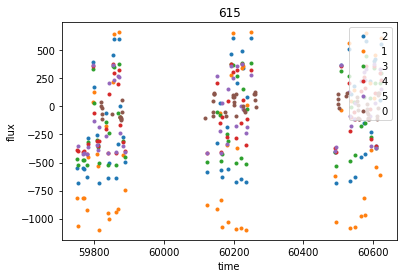

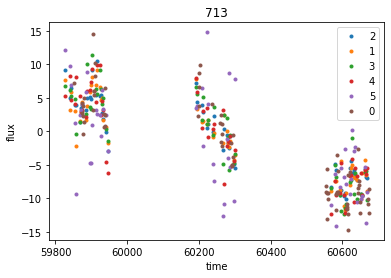

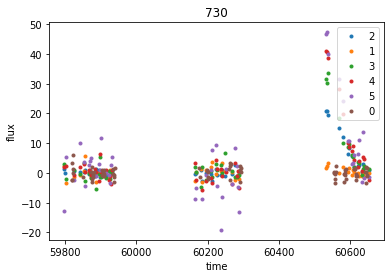

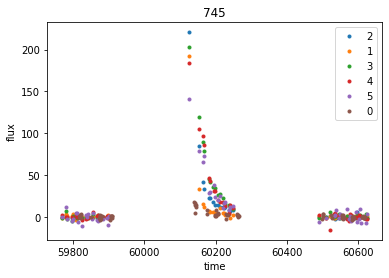

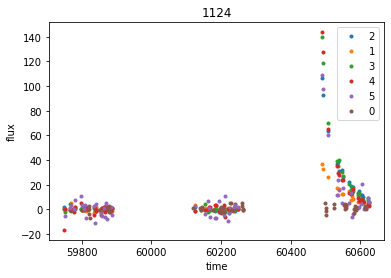

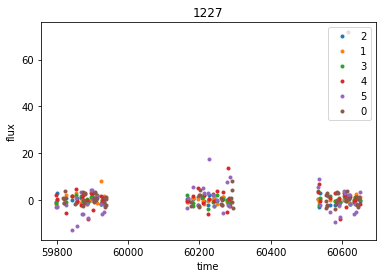

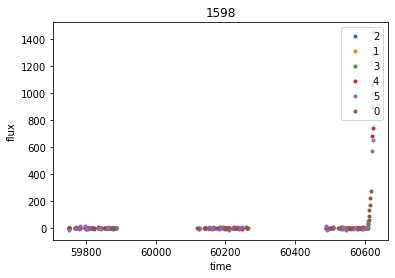

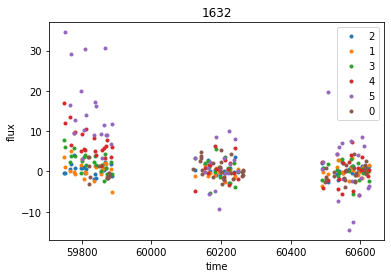

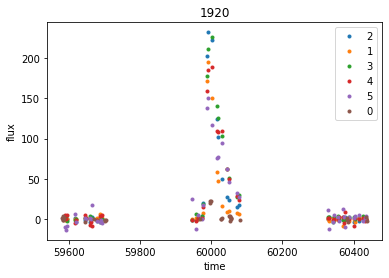

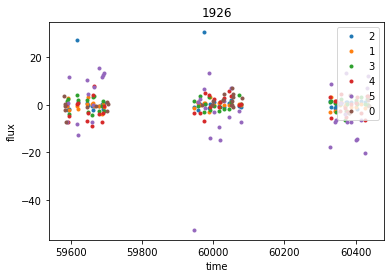

In [13]:
for i in objects[0:10]:
  pl.figure()
  for band in bands:
    dataset = lcvs[(lcvs['object_id'] == i)]
    pl.plot(dataset['mjd'][dataset['passband'] == band],dataset['flux'][dataset['passband'] == band],'.')
  pl.legend(labels = bands, loc = 'upper right')
  pl.xlabel('time')
  pl.ylabel('flux')
  pl.title(i)


Caption: The first ten objects in the list are plotted with flux(y) over time(x)Most of these appear to be static with a few very obvious exceptions.

Plot explicitly object 84716

Text(0.5, 1.0, '84716')

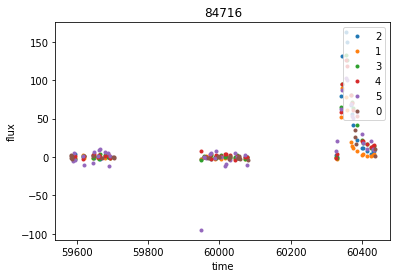

In [14]:
i = 84716

pl.figure()
for band in bands:
  dataset = lcvs[(lcvs['object_id'] == i)]
  pl.plot(dataset['mjd'][dataset['passband'] == band],dataset['flux'][dataset['passband'] == band],'.')
pl.legend(labels = bands, loc = 'upper right')
pl.xlabel('time')
pl.ylabel('flux')
pl.title(i)

Caption: Time series at the six bands of object 8476. For the first two observation period, the flux is mostly stationary. The third observation period shows a sharp spike in flux in the six bands and then a quick return

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

## Features I will select
I think it may be interesting to select the range of values from the original light curve, to show the difference between the highest and lowest flux. I am interested in why some curves are showing relatively stable trends and then a massive flux. I think range will capture this. I also will measure standard deviation of each light curve, as I am interested in the variability. From the standard curve, I think seeing the median datapoint may be intereting as a measure of the distribution of a whole. From the metadata file I will use decl because I don't know what any of the others are.

In [15]:
normalized = lcvs.groupby(['object_id','passband'])[['flux']].transform(lambda x: (x - x.mean()) / x.std())
normalized_error = (lcvs['flux_err'] - lcvs['flux_err'].mean()) / lcvs['flux_err'].std()


In [18]:
normalized_table = pd.concat([lcvs['object_id'], lcvs['passband'], normalized, normalized_error], axis = 1).groupby(['object_id','passband'])
print(normalized_table)


In [24]:
#Creation of my 4 features
ranges = lcvs.groupby(["object_id", "passband"])[["flux"]].max() - lcvs.groupby(["object_id", "passband"])[["flux"]].min()
ranges.columns = ['range']
stdevs = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
stdevs.columns = ['stdev']
normalized_medians = normalized_table['flux'].median()
normalized_errors = normalized_table['flux_err']
normalized_errors.columns = ['Flux error']
normalized_medians.columns = ['normalized median']
decls = metadata['decl']


Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [25]:
#check if you did it right
print("Mean:", normalized_table['flux'].mean())
print("Standard Deviation:", normalized_table['flux'].std())

Mean: object_id  passband
615        0           4.229421e-17
           1           2.871266e-16
           2           6.891039e-17
           3          -8.422382e-17
           4          -6.508204e-17
                           ...     
130779836  1           3.700743e-17
           2           7.549517e-17
           3           1.160688e-16
           4          -2.775558e-17
           5           5.551115e-17
Name: flux, Length: 47088, dtype: float64
Standard Deviation: object_id  passband
615        0           1.0
           1           1.0
           2           1.0
           3           1.0
           4           1.0
                      ... 
130779836  1           1.0
           2           1.0
           3           1.0
           4           1.0
           5           1.0
Name: flux, Length: 47088, dtype: float64


Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



the goodness of fit for these models is also a potential feature

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [27]:
#example
features = ranges.merge(normalized_medians, left_index=True, right_index=True, suffixes = ['_range', '_normalized_median'])
features = features.merge(stdevs, left_index = True, right_index = True)

features.head()

range      flux       stdev
object_id passband                                   
615       0          242.096031 -0.080537   83.944735
          1         1761.066406 -0.170090  601.787302
          2         1293.843445 -0.289021  455.121346
          3          976.381653 -0.122434  335.425053
          4          804.138244 -0.163078  291.803449

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [28]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])


In [137]:
allfeatures['decl'] = decls
allfeatures

passband             0                                           1  \
                 range normalized median        stdev        range   
object_id                                                            
615         242.096031         -0.080537    83.944735  1761.066406   
713          29.245007         -0.052914     7.113509    20.844770   
730           9.402126          0.039463     1.828872     9.086189   
745          21.888378         -0.169349     4.374445   195.862703   
1124         12.135630         -0.033864     2.360084    39.792286   
...                ...               ...          ...          ...   
130739978    74.715691         -0.045003    15.998517   160.918501   
130755807   294.098827         -0.264846    79.713932    56.637408   
130762946   187.755253          0.164351    46.605187    99.415579   
130772921    49.773680         -0.350661    14.420201   327.546928   
130779836  7802.536041         -0.340437  2120.766511  3355.209793   

passband                                             2                    \
          normalized median        stdev         range normalized median   
object_id                                                                  
615               -0.170090   601.787302   1293.843445         -0.289021   
713                0.080189     5.712334     20.596960          0.117188   
730                0.016754     1.807229     23.843549         -0.343392   
745               -0.185994    25.964659    222.954965         -0.290606   
1124              -0.429236     8.107525    108.756227         -0.438785   
...                     ...          ...           ...               ...   
130739978         -0.282994    42.103636     45.919367         -0.281585   
130755807         -0.351126    16.268582     17.692287          0.066620   
130762946          0.081505    23.572412    108.425127         -0.023363   
130772921         -0.302563    97.513710     33.937059         -0.006650   
130779836         -0.513972  1197.557111  31451.568767         -0.355787   

passband                          3                                 \
                 stdev        range normalized median        stdev   
object_id                                                            
615         455.121346   976.381653         -0.122434   335.425053   
713           5.770738    23.724909          0.141552     6.450413   
730           5.559483    39.007901         -0.314425     8.191987   
745          31.957997   208.194738         -0.373246    34.967698   
1124         21.319854   142.618675         -0.383411    26.270649   
...                ...          ...               ...          ...   
130739978     9.781002    34.571276         -0.245053     9.132244   
130755807     4.606559   361.043104         -0.258221    88.177979   
130762946    29.855715   130.471337          0.076775    31.491707   
130772921     6.550608    35.880484         -0.180631     7.667434   
130779836  6440.422386  5036.994083         -0.406302  1443.868085   

passband              4                                             5  \
                  range normalized median         stdev         range   
object_id                                                               
615          804.138244         -0.163078    291.803449    801.003235   
713           22.114735          0.016870      6.406989     28.982050   
730           46.996291         -0.308522     10.710344     66.469870   
745          199.127581         -0.358773     33.069053    151.762677   
1124         160.143942         -0.303771     26.865913    120.018125   
...                 ...               ...           ...           ...   
130739978     81.787758         -0.029408     16.735430    622.977760   
130755807    406.725006         -0.331122    108.319727    204.363800   
130762946     86.768261         -0.107204     22.364118    257.427391   
130772921     40.820330          0.083647     10.112169    263.920414   
130779836  55055.509567 

what is the shape of your final feature space?

In [138]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 19 features (columns)


Now make histograms for allfeatures to show their distributions

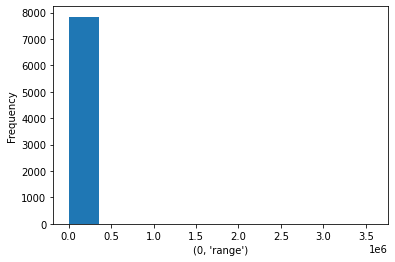

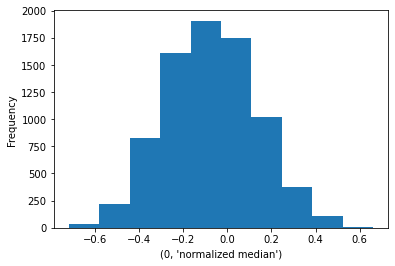

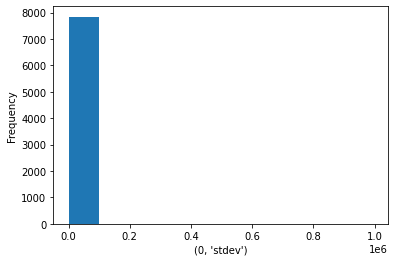

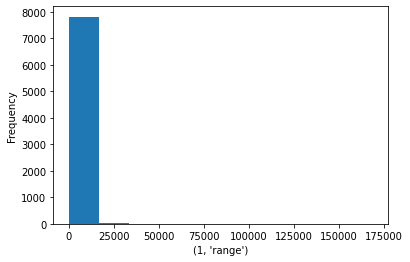

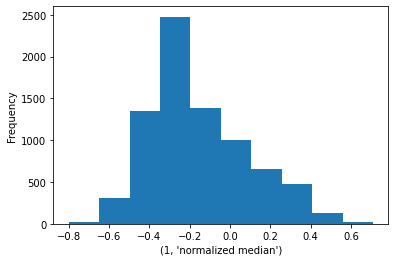

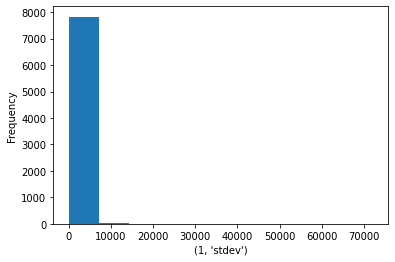

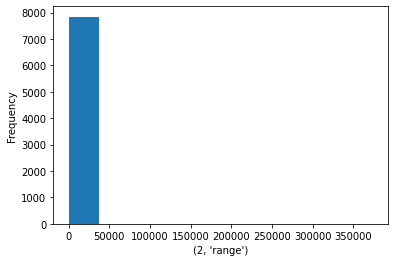

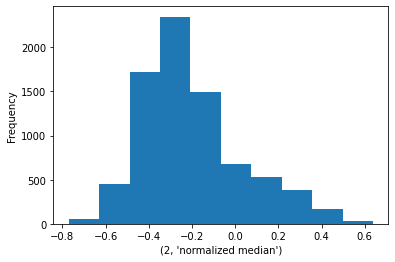

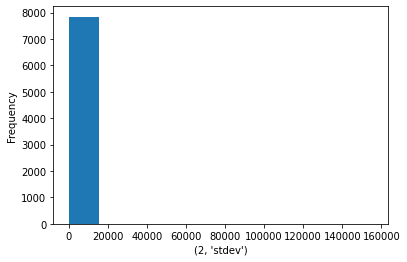

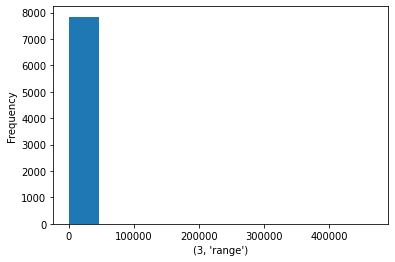

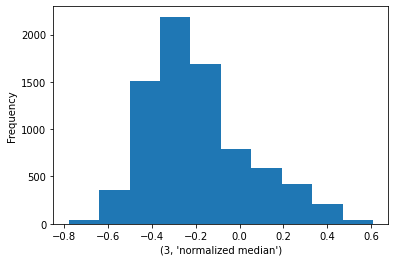

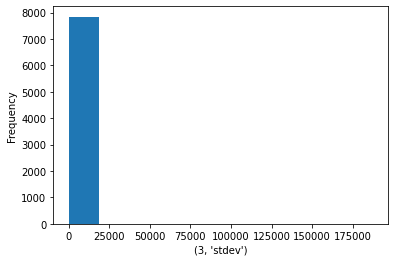

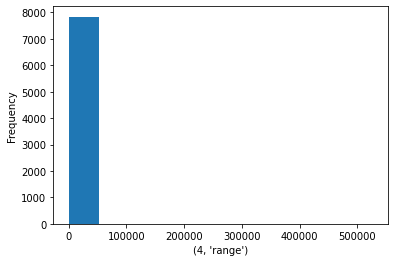

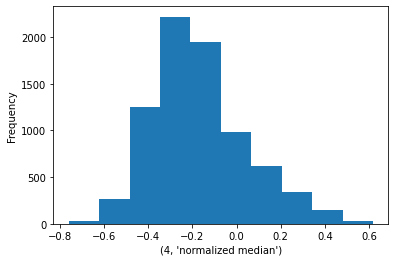

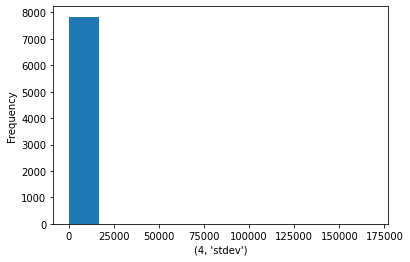

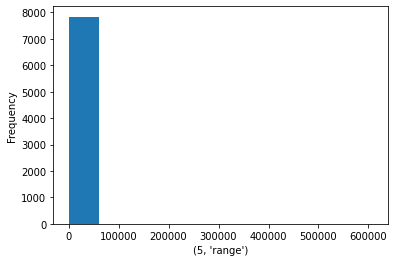

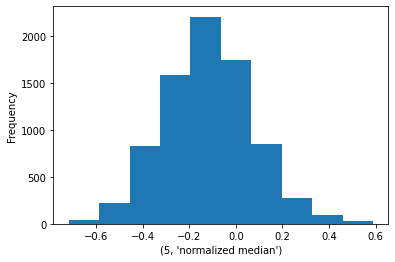

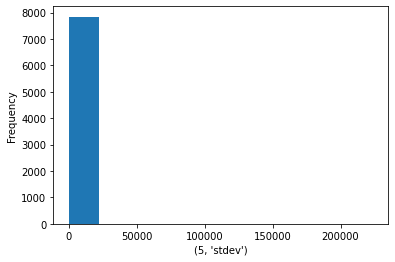

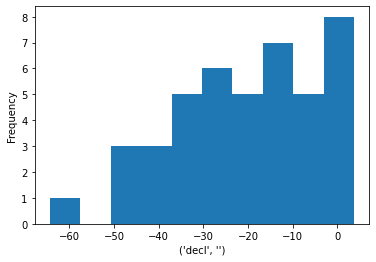

In [139]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

Caption: Distribution of representative features in the datset. standard deviations and range of data are highly clusteres around 0, with median of the normalized dataset carrying a normal distribution around 0. This is the case for all six bands. Decl follows an unusual distribution that may represent the left half of a normal distribution.

# TASK III : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernerl to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

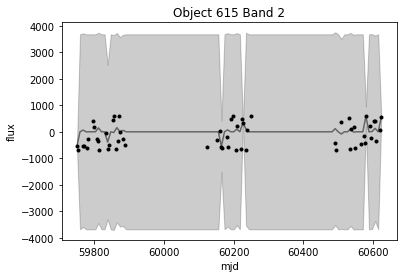

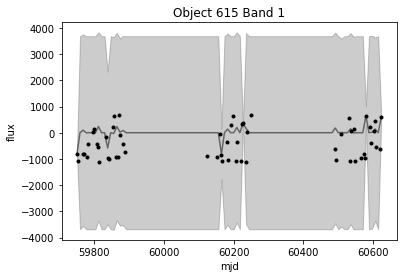

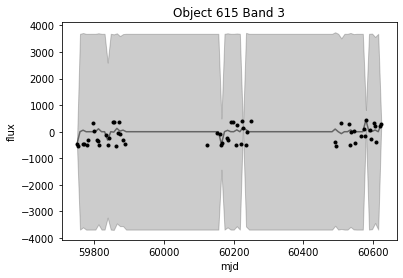

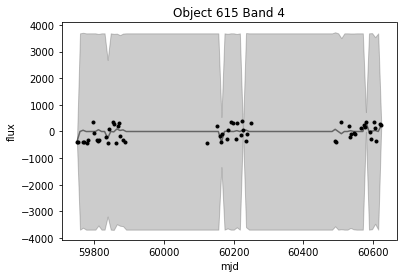

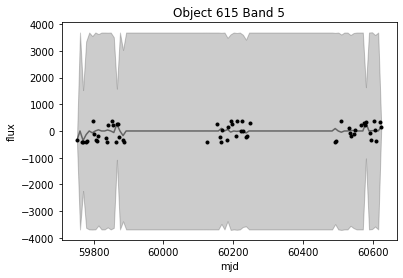

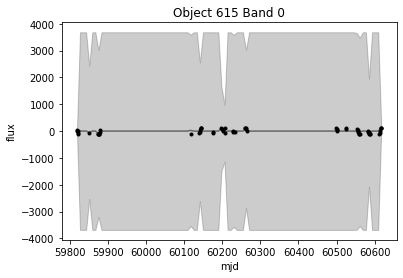

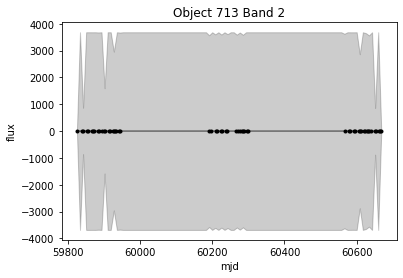

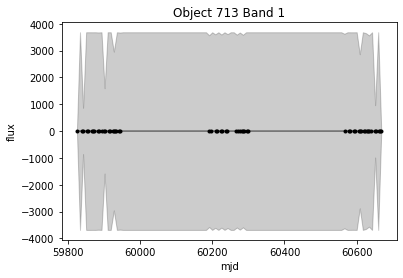

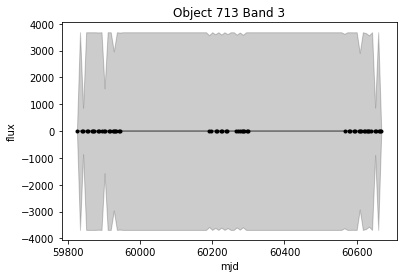

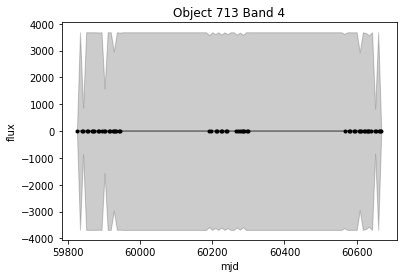

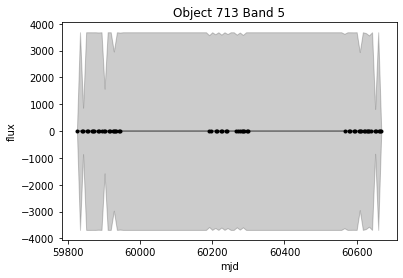

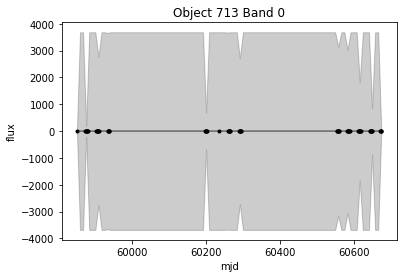

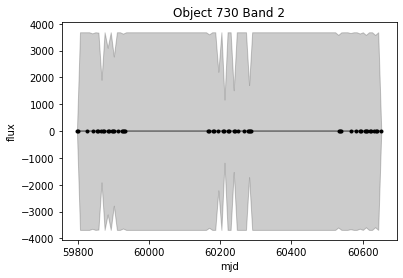

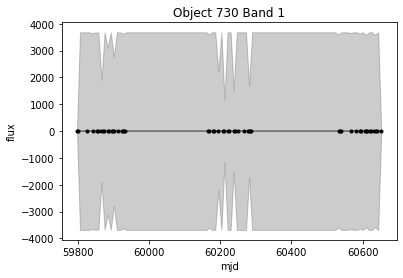

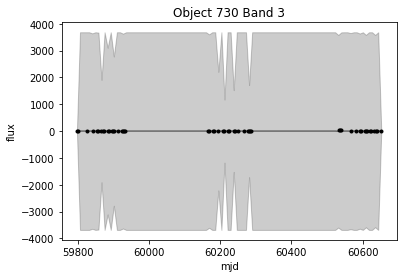

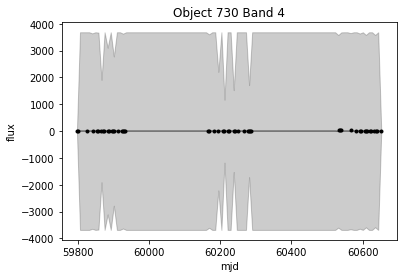

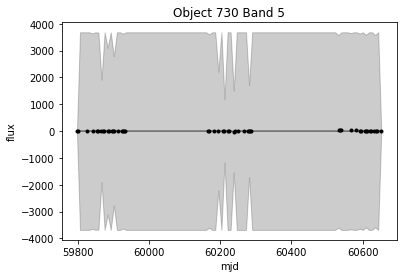

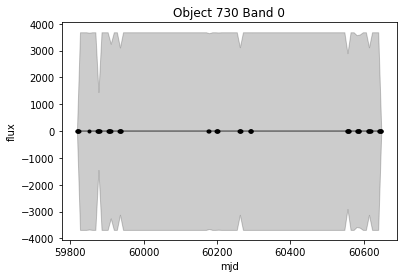

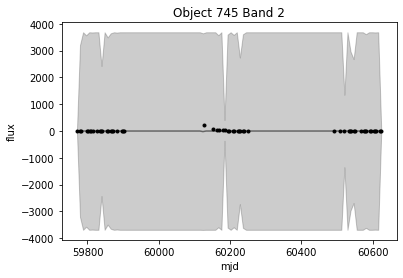

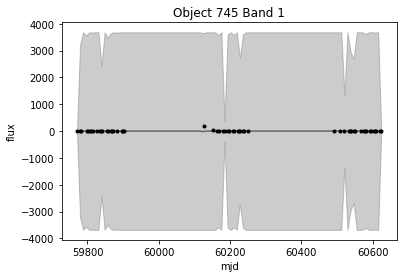

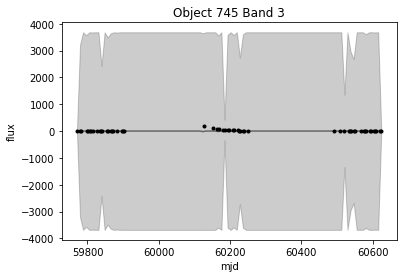

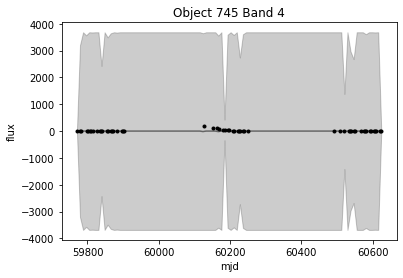

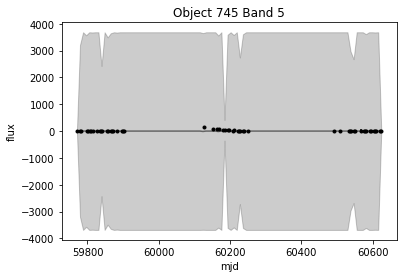

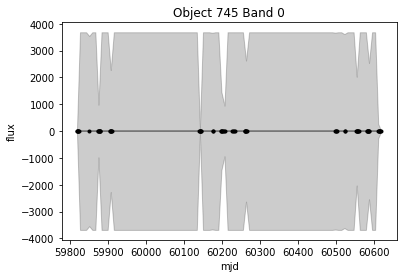

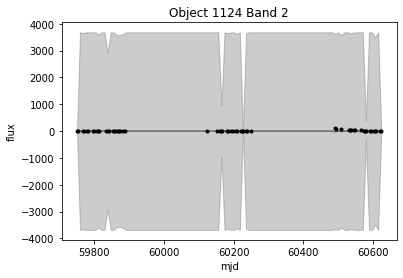

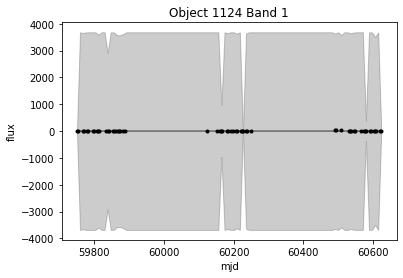

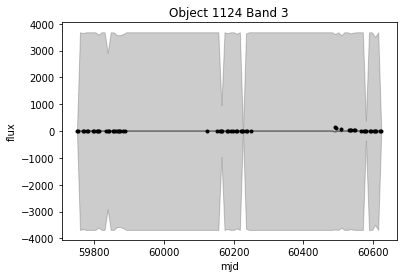

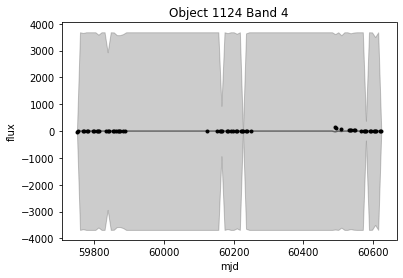

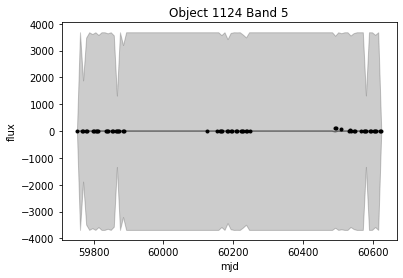

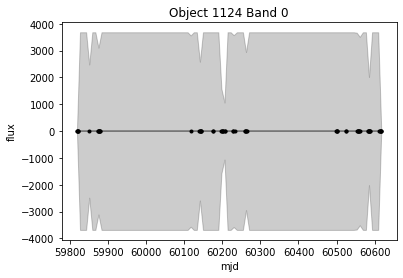

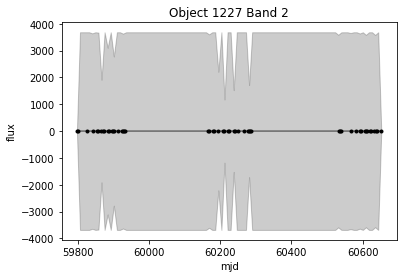

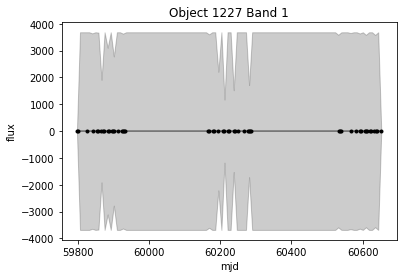

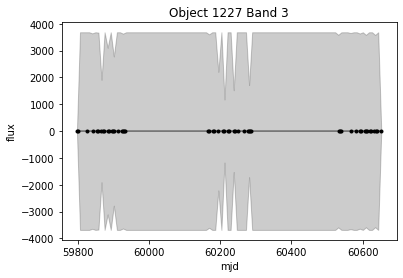

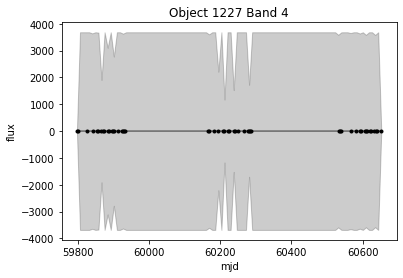

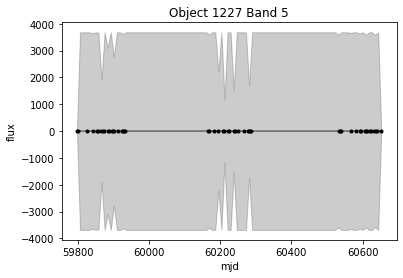

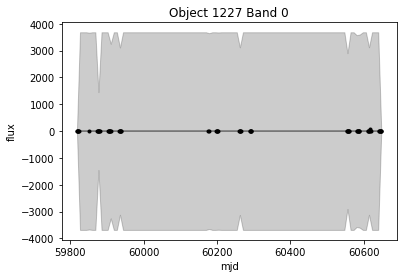

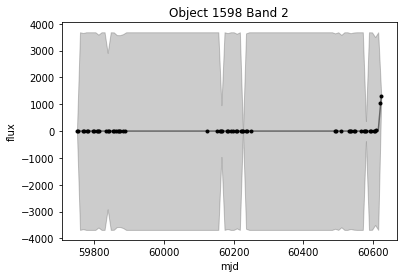

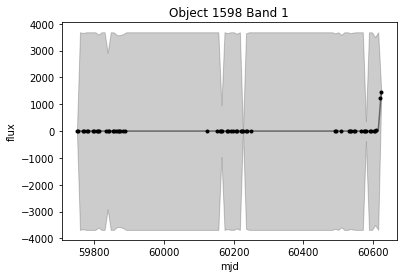

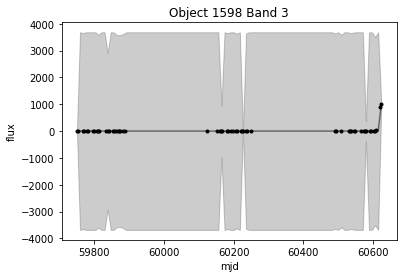

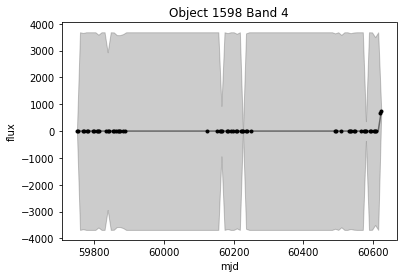

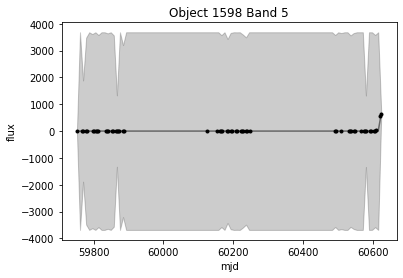

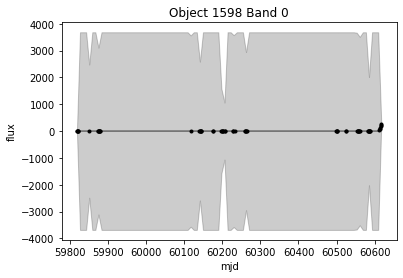

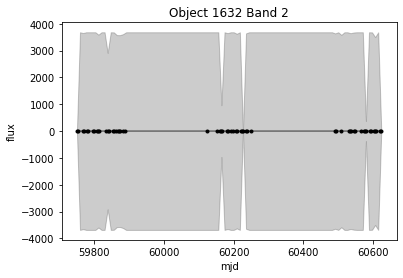

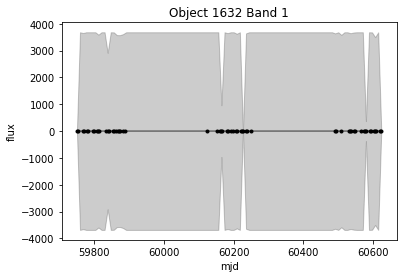

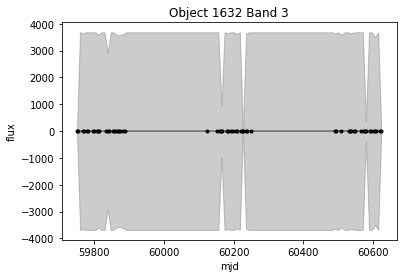

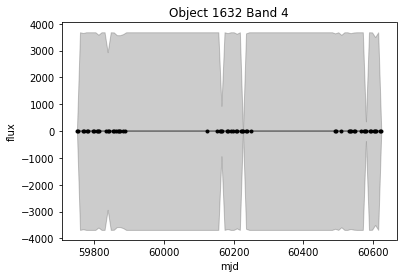

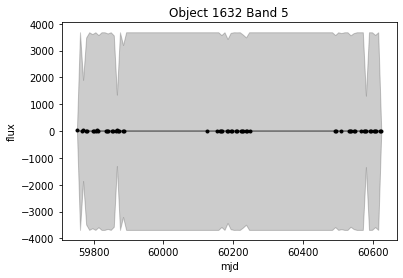

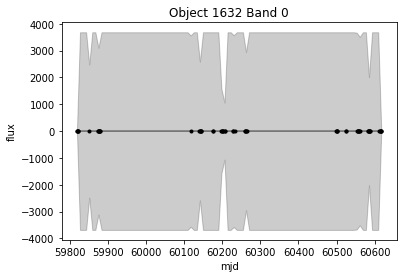

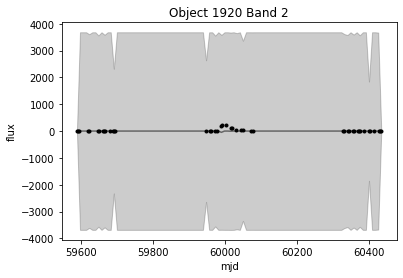

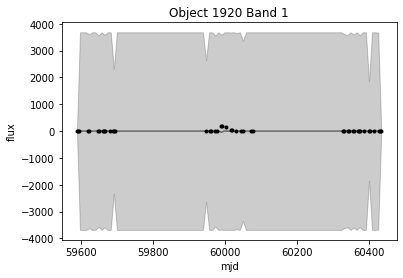

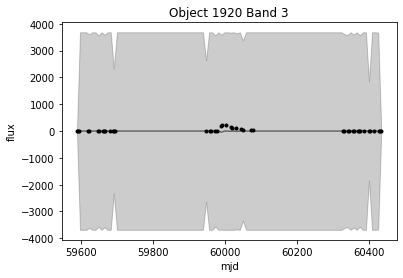

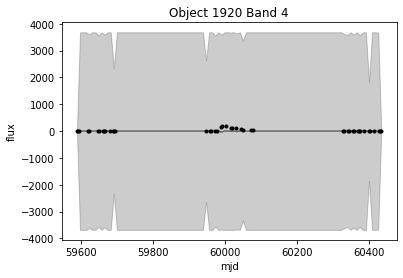

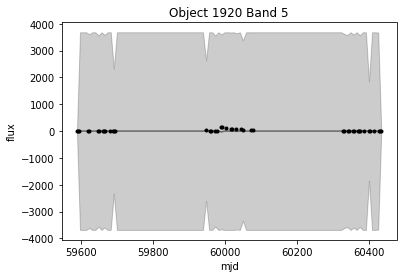

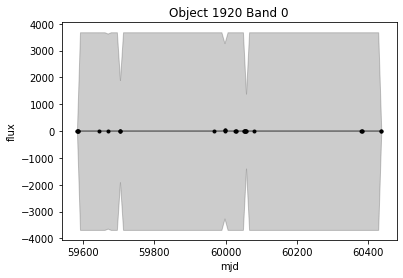

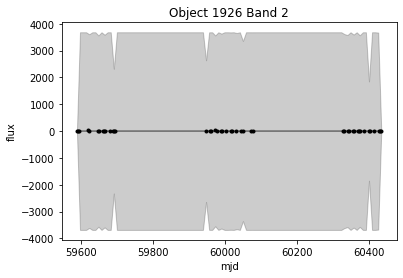

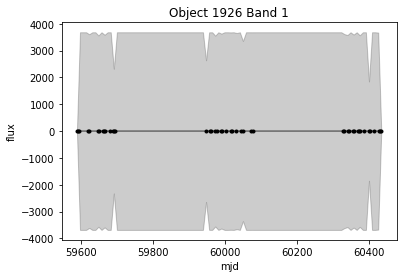

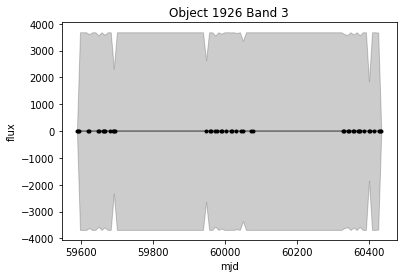

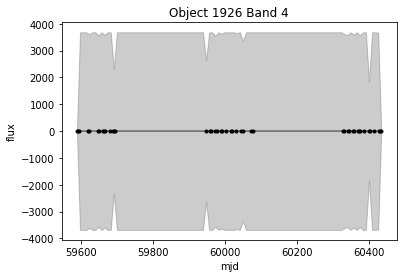

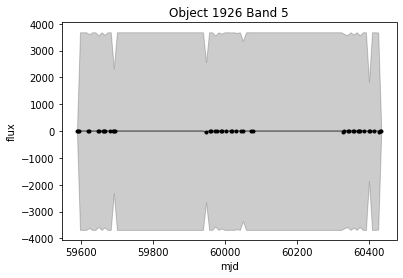

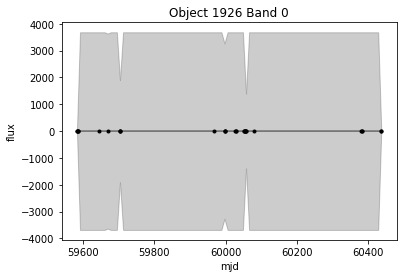

In [73]:
y = lcvs['flux']
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                     kernels.CosineKernel(1))

for object_name in objects[0:10]:
  for band in bands:
    gp = george.GP(kernel)
    t_name = lcvs['mjd'][lcvs['object_id'] == object_name]
    t = t_name[lcvs['passband'] == band].values
    t_pred = linspace(t.min(), t.max(), num =100)
    y_name = lcvs['flux'][lcvs['object_id'] == object_name]
    y = y_name[lcvs['passband'] == band].values
    y_err_name = lcvs['flux_err'][lcvs['object_id'] == object_name]
    y_err = y_err_name[lcvs['passband'] == band].values
    gp.compute(t, y_err) 

    pred, pred_var = gp.predict(y, t_pred, return_var=True)
    pl.figure()
    pl.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
    pl.plot(t_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)
    pl.errorbar(t, y, yerr=y_err, fmt=".k", capsize=0)
    pl.xlabel('mjd')
    pl.ylabel("flux")
    pl.title('Object ' + str(object_name) + ' Band ' + str(band))


Caption: Among the first 10 objects in the dataset and for each band, George gaussian processing is used with a periodic kernel to interpolate data. As can be seen from the shaded grey regions, the 95% confidence intervals are very wide in almost all cases.

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)